# Example Pipeline for Simulated Data

This notebook is a proof-of-concept for generating causal samples from external samples

In [12]:
import sys
sys.path.append("../")  # go to parent dir
import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF

import data.template_causl_simulations as causl_py
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 20,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}

seed = 0
N = 100
sampling_size = 100
causal_params = [0, 1]
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

In [13]:
Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(N=N, seed=0, causal_params=causal_params).values()
uz_disc_samples = get_independent_quantiles(key=jr.PRNGKey(2), z_discr=Z_disc)['u_z_discr']

In [14]:
cont_flows = []
uz_list = [uz_disc_samples]
for d in range(Z_cont.shape[1]):
    Z_d = jnp.array(Z_cont[:, d])[:, None]
    res_d = get_independent_quantiles(key=subkeys[0], z_cont=Z_d, return_z_cont_flow=True, **hyperparam_dict)
    uz_list.append(res_d['u_z_cont'])
    cont_flows.append(res_d['z_cont_flow'])
full_uz_samples = jnp.hstack(uz_list)

 11%|██████████▋                                                                                          | 106/1000 [00:03<00:28, 31.87it/s, train=1.6748982909464412, val=2.04905650706151 (Max patience reached)]


In [15]:
fitted_flow, losses = train_frugal_flow(
    key=subkeys[1],
    y=Y,
    u_z=full_uz_samples,
    condition=X,
    causal_model="location_translation",
    causal_model_args={'ate': 0., **hyperparam_dict},
    **hyperparam_dict
)
causal_margin = fitted_flow.bijection.bijections[-1].bijections[0]

 12%|████████████▎                                                                                      | 124/1000 [00:14<01:45,  8.32it/s, train=-1.0128617016829184, val=5.287712619583747 (Max patience reached)]


## How we can find $U_z$ samples from a fitted copula whilst controlling the $U_{y\mid x}$ samples

In [16]:
u_yx = jr.uniform(key=subkeys[5], shape=(sampling_size, 1))
baseline_uz = jr.uniform(key=subkeys[4], shape=(sampling_size, 4))
frugal_baselines = jnp.hstack([u_yx, baseline_uz])
vmap_frugal_flow = jax.vmap(fun=fitted_flow.bijection.transform, in_axes=(0))
Y_samples = vmap_frugal_flow(x=frugal_baselines, condition=jnp.zeros(u_yx.shape))[:, 0]
uz_samples = vmap_frugal_flow(x=frugal_baselines, condition=jnp.zeros(u_yx.shape))[:, 1:]

In [17]:
print(causal_margin.ate)

0.11560450141566463


(array([ 2.,  3.,  6., 14., 17., 24., 15., 10.,  8.,  1.]),
 array([-3.24467321, -2.61869757, -1.99272193, -1.36674629, -0.74077065,
        -0.11479501,  0.51118063,  1.13715626,  1.7631319 ,  2.38910754,
         3.01508318]),
 <BarContainer object of 10 artists>)

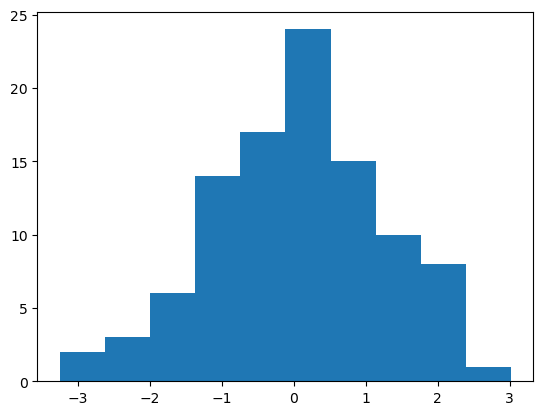

In [18]:
plt.hist(Y_samples)

## Training the propensity score

In [19]:
prop_flow, losses = train_quantile_propensity_score(
    key=subkeys[2],
    x=X.astype(int),
    condition=jnp.hstack([Z_disc, Z_cont])
)
prop_flow_cdf = prop_flow.bijection.transform
vmapped_prop_flow_cdf = jax.vmap(prop_flow_cdf, in_axes=(0,))
u_xz = jr.uniform(subkeys[1], (1000,))[:, None]
u_x = vmapped_prop_flow_cdf(u_xz, condition=jnp.hstack([Z_disc, Z_cont])[:1000])

 32%|███████████████████████████████▎                                                                  | 32/100 [00:02<00:04, 13.68it/s, train=-0.37815551152988847, val=0.12617665458368937 (Max patience reached)]


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 1000: axis 0 of argument x of type float64[1000,1];
  * one axis had size 100: axis 0 of argument condition of type float64[100,4]

## Sampling from Outcome

In [ ]:
u_yx.shape

In [24]:
u_yx

Array([[0.69555037],
       [0.59717649],
       [0.68644425],
       [0.23415381],
       [0.42390942],
       [0.86845339],
       [0.25892348],
       [0.09379605],
       [0.80031149],
       [0.1216242 ],
       [0.93370163],
       [0.56515175],
       [0.01367484],
       [0.9660518 ],
       [0.2077664 ],
       [0.11624545],
       [0.41389261],
       [0.23428709],
       [0.09152609],
       [0.89769684],
       [0.65587679],
       [0.50751934],
       [0.00535324],
       [0.51195375],
       [0.32171458],
       [0.13226835],
       [0.15832441],
       [0.59863833],
       [0.1901867 ],
       [0.73716897],
       [0.33988042],
       [0.31817263],
       [0.77870984],
       [0.69475218],
       [0.22430519],
       [0.13548178],
       [0.4265368 ],
       [0.56948581],
       [0.15646706],
       [0.5275041 ],
       [0.00883914],
       [0.50821979],
       [0.22906333],
       [0.39837609],
       [0.40268561],
       [0.49360637],
       [0.94608948],
       [0.292

In [25]:
outcome_control_samples = sample_outcome(
    frugal_flow=fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=sampling_size,
    causal_model='location_translation',
    causal_condition=jnp.ones((100,1)),
    u_yx=u_yx.flatten(),
    **{'ate': 5}
)
plt.hist(outcome_control_samples);

True
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


/Users/danielmanela/Library/CloudStorage/GoogleDrive-danielmanela@gmail.com/My Drive/work/deep-copula-frugal/validation/../frugal_flows/sample_outcome.py:61: UserWarning: Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
  warnings.warn(


TypeError: LocCond.__init__() got an unexpected keyword argument 'affine_to_standard'

In [ ]:
fitted_flow.cond_shape

In [ ]:
outcome_control_samples = sample_outcome(
    frugal_flow=fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=1000,
    causal_model='location_translation',
    causal_condition=jnp.zeros((1000,1)),
    u_yx=u_yx.flatten(),
    **{'ate': 5}
)
plt.hist(outcome_control_samples);

Process for sampling from our flow:
* Generate a vector of samples for `u_y`
* Sample `u_xz` accordingly
* Use `u_y` to sample from the frugal_copula
* Use `u_xz` to sample `u_x` according to the propensity score.







Working nicely

In [ ]:
fitted_flow.bijection.bijections[-1].bijections[0].ate

ATE Estimate checks out!